In [37]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import accuracy_score

In [38]:
train = datasets.MNIST('/', train=True, 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]),
                       download=True)
test = datasets.MNIST('/', train=False, 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))

                        ]),
                      download=True)

In [39]:
def get_loss(model, dl):
    losses = []
    preds = []
    gts = []
    for x, y in tqdm(dl, desc='Validation'):
        x = x.view(-1, 28 * 28)
        out = model(x)
        loss = criterion(out, y)
        losses.append(loss.item())        
        preds.extend(out.argmax(axis=1).numpy())
        gts.extend(y.numpy())
    
    return np.mean(losses), accuracy_score(gts, preds)

In [40]:
batch_size = 256
epochs = 20
lr = 0.001
max_test_iteration = 25

train_data_loader = DataLoader(train, batch_size=batch_size)
test_data_loader = DataLoader(test, batch_size=batch_size)

In [44]:
state_dicts = []

test_iteration_losses = []
train_iteration_losses = []

train_iteration_acc = []
train_iteration_losses = []

for test_iteration in range(max_test_iteration):
    model = nn.Sequential(
        nn.Linear(28 * 28, 100),
        nn.ReLU(),
        nn.Linear(100, 10)
    )
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        for x, y in tqdm(train_data_loader):
            optimizer.zero_grad()    
            x = x.view(-1, 28 * 28)
            preds = model(x)
            loss = criterion(preds, y)
            epoch_losses.append(loss.item())
            loss.backward()
            optimizer.step()        
        
        test_loss, test_acc = get_loss(model, test_data_loader)
        train_loss, train_acc = get_loss(model, train_data_loader)
        
        print(f'Epoch {epoch} Train loss {train_loss} acc {train_acc:.3f} Test loss {test_loss:.3f} acc {test_acc}')
    
    test_iteration_losses.append(test_loss)
    test_iteration_acc.append(test_acc)
    
    train_iteration_losses.append(train_loss)
    train_iteration_acc.append(train_acc)
    
    state_dicts.append(model.state_dict())


Epoch 0 Train loss 1.9222225863882836 acc 0.553 Test loss 1.909 acc 0.5676



Epoch 0 Train loss 1.9508187319370027 acc 0.525 Test loss 1.935 acc 0.5365


KeyboardInterrupt: 

In [48]:
tries = []

for state_dict in state_dicts:
    values = list(state_dict.values())
    flatten_values = []
    for value in values:
        flatten_values.append(value.flatten())
        
    tries.append(np.concatenate(flatten_values).reshape(1, -1))
tries = np.concatenate(tries)

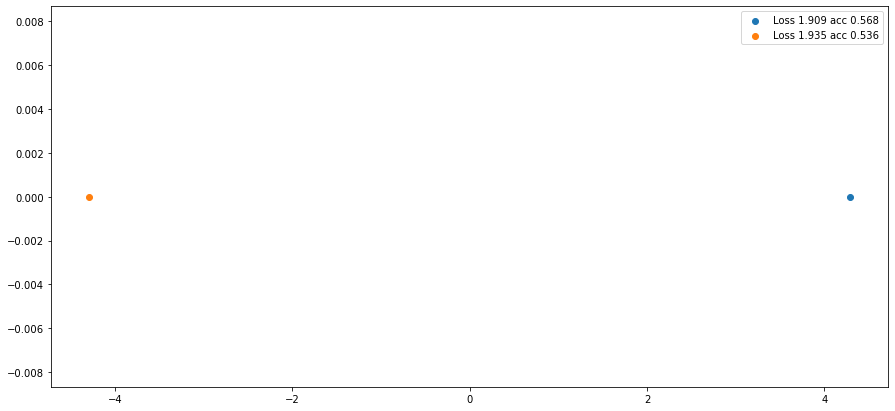

In [49]:
plt.figure(figsize=(15,7))
pca_tries = PCA(2).fit_transform(tries)
for idx,(x,y) in enumerate(pca_tries):
    plt.scatter(x, y, label=f'Loss {test_iteration_losses[idx]:.3f} acc {test_iteration_acc[idx]:.3f}')
    
plt.legend();

In [50]:
pd.DataFrame(pairwise_distances(tries[:10], metric='l2'))

,0,1
0,0.000000,8.578055
1,8.578055,0.000000


In [51]:
pd.DataFrame(tries).to_csv('tries.csv')

In [52]:
# plt.imshow(x.view(batch_size,-1)[0].numpy().reshape(28,28))
#np.linalg.norm(tries[9])
pd.DataFrame(pairwise_distances(pca_tries[:10], metric='l2'))

,0,1
0,0.000000,8.578042
1,8.578042,0.000000


In [53]:
test_iteration_losses_df = pd.DataFrame(test_iteration_losses)#.to_csv('test_iteration_losses.csv')

In [54]:
test_iteration_acc_df = pd.DataFrame(test_iteration_acc)# .to_csv('test_iteration_acc.csv')

Text(0.5, 0, 'Loss function value')

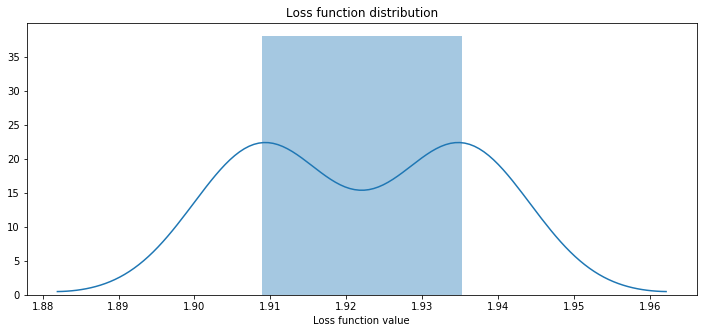

In [56]:
# test_iteration_losses_df.hist(bins=10)
# plt.grid(False)
plt.figure(figsize=(12,5))
sns.distplot(test_iteration_losses_df)
plt.title('Loss function distribution')
plt.xlabel('Loss function value')

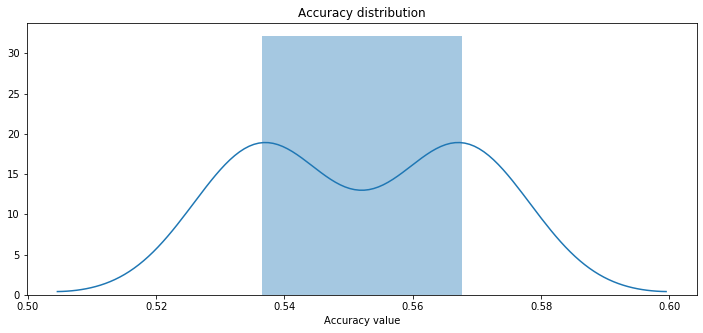

In [57]:
plt.figure(figsize=(12,5))
sns.distplot(test_iteration_acc)
plt.title('Accuracy distribution')
plt.xlabel('Accuracy value');